# Preparing the dataset for hippocampus segmentation


In [29]:
# Import necessary libraries: nibabel, matplotlib, numpy
import nibabel as nib
import numpy as np
import os, glob, shutil
import matplotlib.pyplot as plt

In [9]:
image_path = "/data/TrainingSet/images/"
label_path = "/data/TrainingSet/labels/"

images = sorted(glob.glob(os.path.join(image_path,'*.nii.gz')))
labels = sorted(glob.glob(os.path.join(label_path,'*.nii.gz')))
len(images), len(labels)

(263, 262)

In [10]:
image_names = [x.split('/')[-1] for x in images]
label_names = [x.split('/')[-1] for x in labels]
mismatch = list(set(image_names) - set(label_names))
print(mismatch)

['hippocampus_118.nii.gz']


In [11]:
for file in mismatch:
    image_names.remove(file)
len(image_names), len(label_names)

(262, 262)

In [12]:
def shape(path, names, threshold):
    outlier = []
    for name in names:  
        x, y, z = nib.load(os.path.join(path, name)).get_fdata().shape
        if (x > threshold) | (y > threshold) | (z > threshold):
            outlier.append(name)
            print(name)
            print(x, y, z)
            print()
    return outlier

image_outlier = shape(image_path, image_names, 60)
label_outlier = shape(label_path, label_names, 60)

print(list(set(image_outlier).union(set(label_outlier))))

# remove the outliers
for name in list(set(image_outlier).union(set(label_outlier))):
    image_names.remove(name)
    label_names.remove(name)

assert image_names == label_names, 'FileMismatchError.'

print(len(image_names), len(label_names))

hippocampus_010.nii.gz
512 512 241

hippocampus_281.nii.gz
512 512 31

hippocampus_281.nii.gz
512 512 94

['hippocampus_281.nii.gz', 'hippocampus_010.nii.gz']
260 260


In [82]:
# Load an image and a segmentation mask into variables called image and label

img_n = 65
image = nib.load(os.path.join(image_path, image_names[img_n])).get_fdata()
label = nib.load(os.path.join(label_path, label_names[img_n])).get_fdata()
print(image.dtype)
print(label.dtype)
print(image.shape)
print(label.shape)

float64
float64
(33, 47, 37)
(33, 47, 37)


In [83]:
def display_volume_slices(img, w, h):
    plot_w = w
    plot_h = h

    # You can play with figsize parameter to adjust how large the images are
    fig, ax = plt.subplots(plot_h, plot_w, figsize=[35,25])

    for i in range(plot_w*plot_h):
        plt_x = i % plot_w
        plt_y = i // plot_w
        
        if (i < len(img)):
            ax[plt_y, plt_x].set_title(f"slice {i}")
            ax[plt_y, plt_x].imshow(np.fliplr(np.rot90(img[i])), cmap='gray')
        ax[plt_y, plt_x].axis("off")

    plt.show()

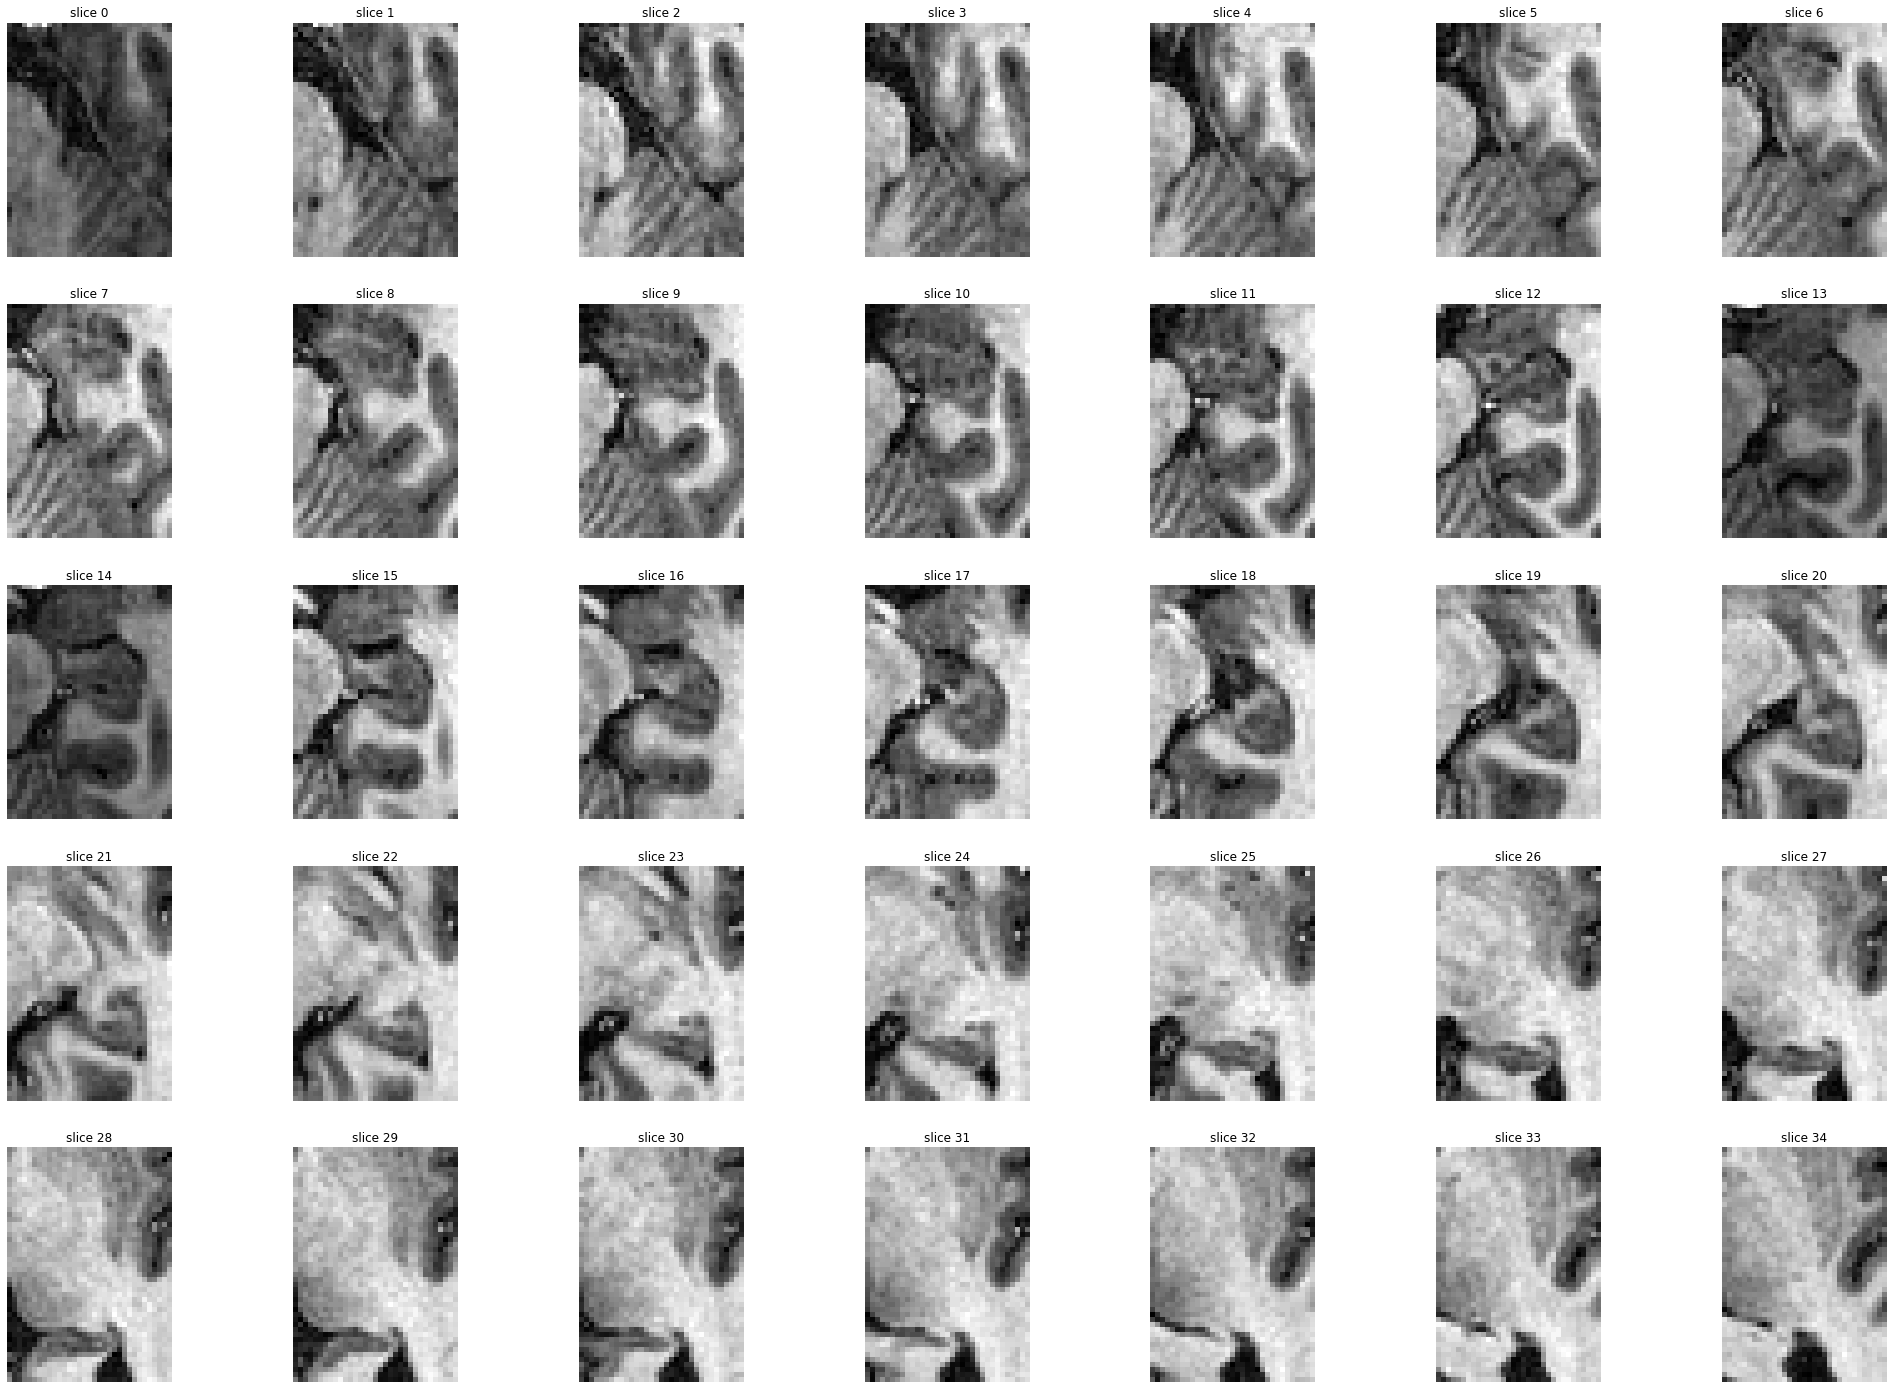

In [84]:
display_volume_slices(np.transpose(image, (2, 0, 1)), 7, 5)

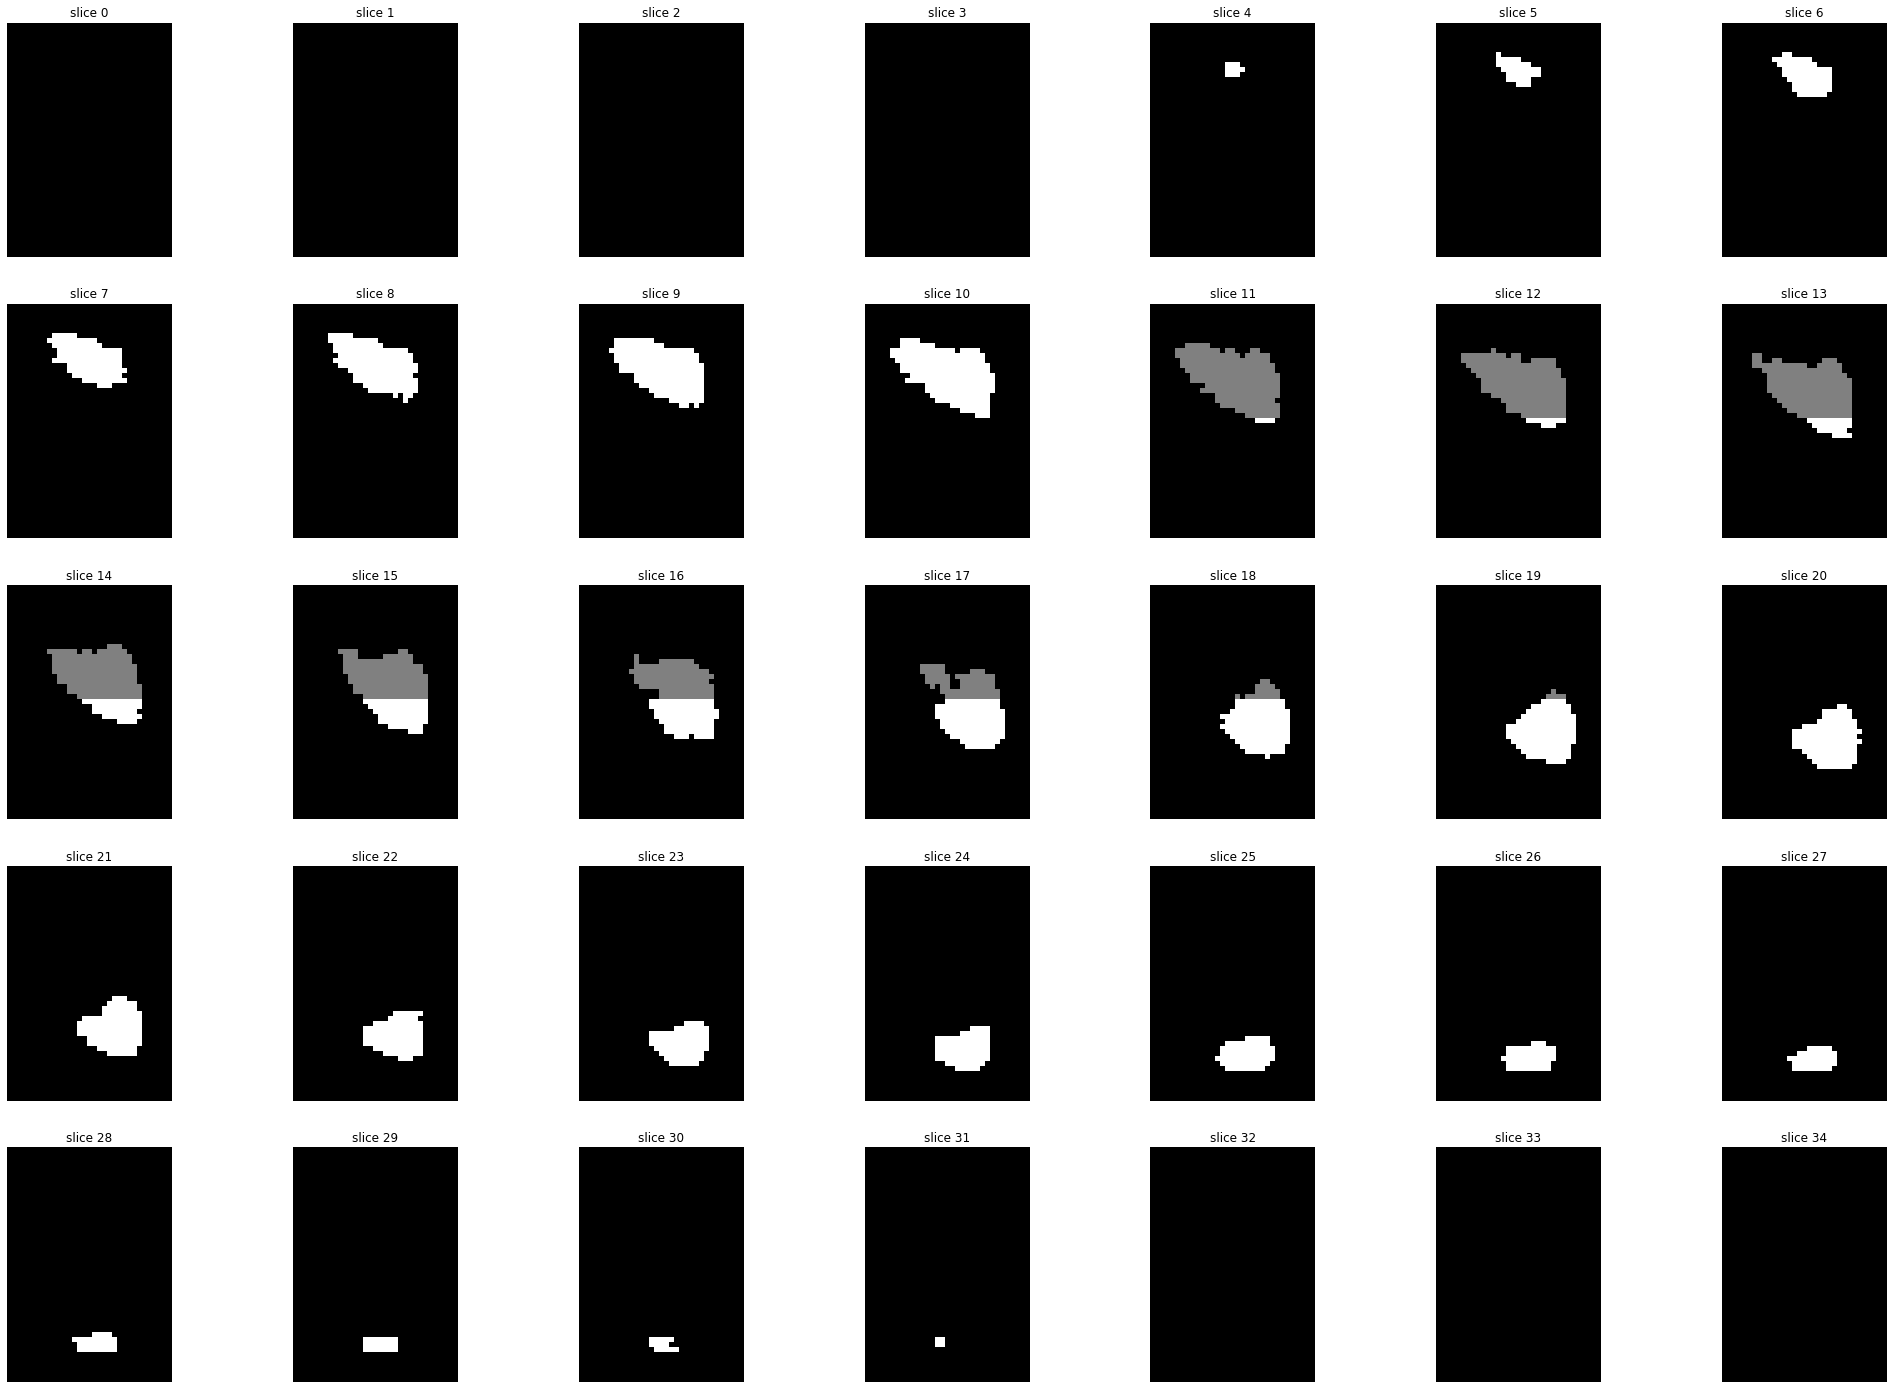

In [85]:
display_volume_slices(np.transpose(label, (2, 0, 1)), 7, 5)

## Looking at single image data
In this section we will look closer at the NIFTI representation of our volumes. In order to measure the physical volume of hippocampi, we need to understand the relationship between the sizes of our voxels and the physical world.

In [17]:
# format of images?
img = nib.load(os.path.join(image_path, image_names[img_n]))
print(img.header_class)

<class 'nibabel.nifti1.Nifti1Header'>


In [18]:
print(img.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [ 3 34 52 35  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'5.0.10'
aux_file        : b'none'
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 1.0
qoffset_y       : 1.0
qoffset_z       : 1.0
srow_x          : [1. 0. 0. 1.]
srow_y          : [

Further down we will be inspecting .header attribute that provides access to NIFTI metadata. You can use this resource as a reference for various fields: https://brainder.org/2012/09/23/the-nifti-file-format/

In [19]:
# bits per pixel?
print('Bits per pixels: ', img.header['bitpix'])

Bits per pixels:  32


In [20]:
# units of measurement?
unit_b = int(str(img.header['xyzt_units'].item()), base=2)
unit_d = img.header['xyzt_units']

print(f'Units of measurement: {unit_d} in decimal , {unit_b} in binary.')
spatial_unit, temporal_unit = img.header.get_xyzt_units()
print(f"Spatial unit: {spatial_unit}, Temporal unit: {temporal_unit}")

Units of measurement: 10 in decimal , 2 in binary.
Spatial unit: mm, Temporal unit: sec


In [21]:
# regular grid? grid spacings?
print('Grid Spacing: ', img.header['pixdim'])

Grid Spacing:  [1. 1. 1. 1. 1. 0. 0. 0.]


According to the grid spacing, we have a regular grid with a voxel size of 1x1x1 mm<sup>3</sup>

In [22]:
# What dimensions represent axial, sagittal, and coronal slices? How do you know?
print(nib.aff2axcodes(img.affine))
print("Orientation is R A S, i.e., left to Right (sagittal or X direction), \
posterior to Anterior (coronal or Y direction), and inferior to Superior \
(axial or Z direction), respectively.")

('R', 'A', 'S')
Orientation is R A S, i.e., left to Right (sagittal or X direction), posterior to Anterior (coronal or Y direction), and inferior to Superior (axial or Z direction), respectively.


In [23]:
# Compute the volume (in mm³) of a hippocampus using one of the labels loaded. 
label = nib.load(os.path.join(label_path, label_names[img_n]))
label_np = label.get_fdata()
np.sum(label_np != 0)

3353

## Plotting some charts

In [24]:
# Plot a histogram of all volumes that we have in our dataset and see how 
# our dataset measures against a slice of a normal population represented by the chart below.

<img src="img/nomogram_fem_right.svg" width=400 align=left>

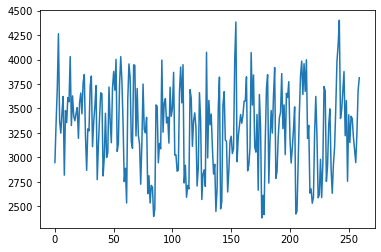

In [25]:
volumes = []

for label_name in label_names:
    label_file = os.path.join(label_path, label_name)
    label = nib.load(label_file)          # Load the NIFTI file
    label_slices = label.get_fdata()      # Load the array 
    volume = (label_slices > 0).sum()     # Calculate the volume
    
    # Check for outliers
    if volume > 5000 or volume < 2000:
        file_name = label_file.split('/')[-1]
        outliers.add(file_name)
        print("Volume of file {} ({}) exceeds expected value (~4500).".format(file_name, volume))
    
    volumes.append(volume)

plt.plot(volumes)

In the real world we would have precise information about the ages and conditions of our patients, and understanding how our dataset measures against population norm would be the integral part of clinical validation that we talked about in last lesson. Unfortunately, we do not have this information about this dataset, so we can only guess why it measures the way it is.

The mask seems to have two classes, labeled with values `1` and `2` respectively. Class 1 is the anterior segment of the hippocampus and class 2 is the posterior one. For the purpose of volume calculation we do not care about the distinction, however we will still train our network to differentiate between these two classes and the background.

(array([ 4.,  2.,  2.,  3.,  2.,  6.,  4.,  6.,  6.,  4.,  4.,  6.,  6.,
         9.,  4.,  5.,  5.,  8.,  9.,  8., 12.,  6.,  7.,  7.,  9., 10.,
        11.,  8.,  7.,  8.,  9.,  9., 10.,  7.,  3.,  6.,  5.,  2.,  6.,
         6.,  3.,  2.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  2.]),
 array([2382.  , 2422.38, 2462.76, 2503.14, 2543.52, 2583.9 , 2624.28,
        2664.66, 2705.04, 2745.42, 2785.8 , 2826.18, 2866.56, 2906.94,
        2947.32, 2987.7 , 3028.08, 3068.46, 3108.84, 3149.22, 3189.6 ,
        3229.98, 3270.36, 3310.74, 3351.12, 3391.5 , 3431.88, 3472.26,
        3512.64, 3553.02, 3593.4 , 3633.78, 3674.16, 3714.54, 3754.92,
        3795.3 , 3835.68, 3876.06, 3916.44, 3956.82, 3997.2 , 4037.58,
        4077.96, 4118.34, 4158.72, 4199.1 , 4239.48, 4279.86, 4320.24,
        4360.62, 4401.  ]),
 <a list of 50 Patch objects>)

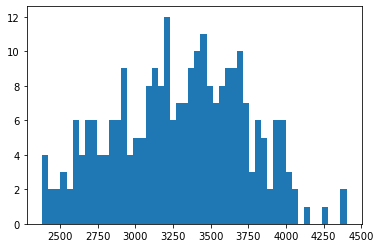

In [26]:
plt.hist(volumes, bins=50)

In [31]:
# Copy the clean dataset to the output folder inside section1/out

out_images_path = 'out/images/'
out_labels_path = 'out/labels/'

os.makedirs(os.path.dirname(out_images_path), exist_ok=True)
os.makedirs(os.path.dirname(out_labels_path), exist_ok=True)

for image_name in image_names:
    image_file = os.path.join(image_path, image_name)
    shutil.copy(image_file, out_images_path)
    label_file = os.path.join(label_path, image_name)
    shutil.copy(label_file, out_labels_path)
        
print("Number of images in clean dataset: ", len(os.listdir(out_images_path)))
print("Number of labels in clean dataset: ", len(os.listdir(out_labels_path)))

Number of images in clean dataset:  260
Number of labels in clean dataset:  260


## Final remarks

In the next section we will create training and testing pipelines for a UNet-based machine learning model, run and monitor the execution, and will produce test metrics.